<a href="https://colab.research.google.com/github/joshuamwalker/Roeslein/blob/main/MonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import numpy as np

class generic_instrument:
  '''
  Input Arguments:
    ActualValue: Actual value of the parameter the instrument is measuring
    PctError: Percent error of the instrument (percentage of actual value)
    ErrorType: Normal or Uniform
    Ni: Number of iterations to generate (typ. 1e6)
    EngUnits: User-defined string, used in plotting
  '''
  def __init__(self, ActualValue, PctError, ErrorType, Ni, EngUnits=''):
    self.ActualValue = ActualValue
    self.PctError = PctError
    self.ErrorType = ErrorType
    self.EngUnits = EngUnits
    if self.ErrorType == 'Normal':
      # For normal distribution, PctError is taken as the 1-sigma value
      self.StdDev = self.ActualValue * self.PctError / 100
      self.MeasuredValues = np.random.normal(self.ActualValue, self.StdDev, int(Ni)) # Normal error distribution
      self.MinMeas = self.ActualValue - self.StdDev # Not used for computation but provided for assistance when plotting
      self.MaxMeas = self.ActualValue + self.StdDev # Not used for computation but provided for assistance when plotting
    elif self.ErrorType == 'Uniform':
      # For uniform distribution, PctError is taken as the min/max distance from the actual value value
      self.MinMeas = self.ActualValue * (1 - self.PctError / 100) # Minimum measurement
      self.MaxMeas = self.ActualValue * (1 + self.PctError / 100) # Maximum measurement
      self.MeasuredValues = np.random.uniform(self.MinMeas, self.MaxMeas, int(Ni)) # Uniform error distribution
    else:
      print('Error: Error distribution type not specified')
      return 0
    self.StdDev = np.std(self.MeasuredValues) # Not used for computation but provided for assistance when plotting
    if self.ActualValue != 0:
      self.RelStdDev = self.StdDev / self.ActualValue # Not used for computation but provided for assistance when plotting
    else:
      self.RelStdDev = 0

class ultrasonic_flowmeter():
  def __init__(self, X_config, X_mixture, PctError, ErrorType, Ni, PrintOutput, StreamName):
    '''
    Error and ErrorType should be that of the raw speed of sound measurement
    '''
    if 1: # Molecular weights and adiabatic indices of components
      M_H = 1.008
      M_C = 12.011
      M_N = 14.007
      M_O = 15.999
      M_CH4 = M_C + M_H * 4
      M_CO2 = M_C + M_O * 2
      M_O2 = M_O * 2
      M_N2 = M_N * 2
      M_H2O = M_O + M_H * 2
      gamma_CH4 = 1.32
      gamma_CO2 = 1.28
      gamma_O2 = 1.40
      gamma_N2 = 1.40
      gamma_H2O = 1.33
    M_arr = np.array([M_CH4, M_CO2, M_O2, M_N2, M_H2O])
    gamma_arr = np.array([gamma_CH4, gamma_CO2, gamma_O2, gamma_N2, gamma_H2O])
    R = 8.314 # J/mol/K
    T = 301.4 # K
    # Calculate internal device configuration parameters
    self.X_config = np.array(X_config) / np.sum(X_config) * 100 # Normalize calibration mixture composition
    self.M_other_config = np.dot(M_arr[1:], self.X_config[1:] / np.sum(self.X_config[1:])) # Calculate molar mass of non-CH4 compounds
    self.gamma_other_config = np.dot(gamma_arr[1:], self.X_config[1:] / np.sum(self.X_config[1:]))
    # Calculate actual values of mixture
    self.X_mixture = np.array(X_mixture) / np.sum(X_mixture) * 100 # Normalize mixture composition
    self.ActualValue = self.X_mixture[0]
    self.M_mixture = np.dot(M_arr, self.X_mixture / 100) # Calculate molar mass of entire mixture
    self.gamma = np.dot(gamma_arr, self.X_mixture / 100) # Calculate gamma (adiabatic index) of entire mixture
    self.c_mixture = np.sqrt(self.gamma * R * T * 1000 / self.M_mixture)
    # Calculate flowmeter measured speed of sound, accounting for instrument error
    self.c_measured = generic_instrument(self.c_mixture, PctError, ErrorType, Ni, '%mol').MeasuredValues # Measured molar mass of entire mixture
    # Replicate flowmeter internal calculation
    self.X_meas_numerator = self.gamma_other_config * R * T * 1000 / self.c_measured**2 - self.M_other_config
    self.X_meas_denominator = (M_CH4 - self.M_other_config) - (gamma_CH4 - self.gamma_other_config) * (R * T * 1000 / self.c_measured**2)
    self.MeasuredValues = self.X_meas_numerator / self.X_meas_denominator * 100
    self.Mean_meas = np.mean(self.MeasuredValues)
    self.AbsErr = self.Mean_meas - self.X_mixture[0]
    self.RelErr = self.AbsErr / self.X_mixture[0] * 100
    self.StdDev = np.std(self.MeasuredValues)
    self.RelStdDev = self.StdDev / self.X_mixture[0] * 100
    if PrintOutput:
      print(StreamName)
      print('     Actual CH4 = %1.3f %%mol' % self.ActualValue)
      print('      M_mixture = %1.3f g/mol' % self.M_mixture)
      print('   Measured CH4 = %1.3f %%mol' % self.Mean_meas)
      print(' Absolute Error = %1.3f %%mol' % self.AbsErr)
      print(' Relative Error = %1.3f %%' % self.RelErr)
      print('      AbsStdDev = %1.3f %%mol' % self.StdDev)
      print('      RelStdDev = %1.3f %%' % self.RelStdDev)
      print()

In [240]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_hist_imbalance(E, ax, nbins=50, title='Methane Imbalance (SCFM_CH4)', format=True):
  pct_neg_imbalance = np.sum(E < 0) / len(E)
  std_imbalance = np.std(E, ddof=1)

  bin_edges = np.linspace(E.min(), E.max(), nbins + 1)

  # Plot histogram
  bars = sns.histplot(E, bins=nbins, stat='count', ax=ax, color='steelblue', alpha=0.8, edgecolor='none', zorder=4)

  # Shade bars < 0
  for patch in bars.patches:
    if patch.get_x() < 0:
      patch.set_facecolor('crimson')
      patch.set_alpha(0.8)

  if format:
    # Format plot
    ax.set_xlabel('Methane Imbalance (SCFM_CH4)')
    ax.set_xlim([-2.5,5])
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.set_yticklabels([])
    ax.grid(False)
    ax.set_title(title)

    # Annotation at top-left
    ax.annotate(f'{pct_neg_imb:.1%} ≤ 0',
                xy=(0.02, 0.95), xycoords='axes fraction',
                ha='left', va='top', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.8))
  return pct_neg_imbalance, std_imbalance

def plot_hist_measurements(CH4_F, CH4_P, CH4_T, ax, nbins=50, title="Methane In vs. Out", xlims=[-5,65], vlines=None):
  sns.histplot(CH4_F, bins=nbins, stat='count', ax=ax, color='saddlebrown', alpha=0.8, edgecolor='none', label='Inlet CH4 Measurement', zorder=5)
  sns.histplot(CH4_P, bins=nbins,  stat='count', ax=ax, color='orange', alpha=0.8, edgecolor='none', label='Product CH4 Measurement', zorder=4)
  # sns.histplot(CH4_T, bins=nbins,  stat='count', ax=ax, color='steelblue', alpha=0.8, edgecolor='none', label='Tailgas CH4 (Calculated)', zorder=3)
  pct_neg_imbalance, std_imbalance = plot_hist_imbalance(E, ax, nbins=50, title='Methane Imbalance (SCFM_CH4)', format=False)
  bars = sns.histplot([-100], ax=ax, color='steelblue', alpha=0.8, edgecolor='none', label=f'Tailgas CH4 (Calculated)\n(Accuracy ±{std_imbalance*2:.2f} SCFM_CH4)', zorder=3)
  bars = sns.histplot([-100], ax=ax, color='crimson', alpha=0.8, edgecolor='none', label=f'Measured Negative Imbalances\n({pct_neg_imbalance:.1%} of measurements)', zorder=3)

  # Draw vertical lines at nominal flowrates
  for vline in vlines:
    ax.axvline(x=vline, color='black', linestyle='--', linewidth=1.5, zorder=10)

  ax.set_xlim(xlims)
  ax.set_title(title)
  ax.set_xlabel('Measured Methane Flowrates (SCFM_CH4)')
  ax.set_ylabel("")
  ax.set_yticks([])
  ax.set_yticklabels([])
  ax.grid(False)
  ax.legend(loc='upper center')


[96. 97. 98.]
[57.6 58.2 58.8]
[0.06  0.045 0.03 ]
[2.4 1.8 1.2]
2.4226122900835314
4.037687150139219
2.427907585176471
4.046512641960785
2.4213114878710558
4.035519146451759


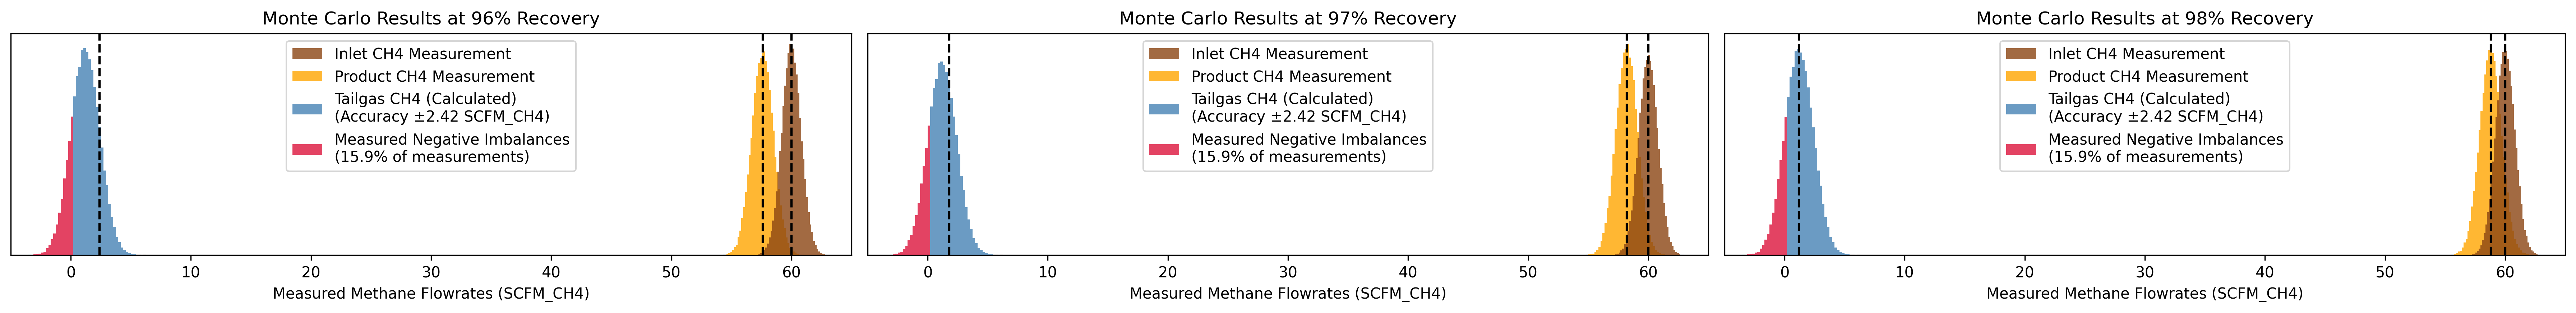

In [299]:
# Given simulation conditions
n = 1e5
F_F = 100 # SCFM
X_F = 60 # mol%
F_P = F_F * 0.6 # SCFM
Rs = np.array([96, 97, 98])  # % Recovery
X_Ps = F_F * X_F / 100 * Rs / 100 / F_P * 100 # mol%
F_Ts = F_F - F_P # SCFM
X_Ts = (F_F * X_F / 100 - F_P * X_Ps / 100) / F_Ts # mol%

print()
print(X_Ps)
print(F_P*X_Ps/100)
print(X_Ts)
print(F_Ts*X_Ts)

# rows, cols = len(Rs), 1
rows, cols = 1, len(Rs)
fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 3 * rows), dpi=300)

# Run simulations
for i in range(len(Rs)):
  R = Rs[i]
  X_P = X_Ps[i]
  distribution = 'Normal'
  sigma_multiplier = 2
  FT_3131 = generic_instrument(F_F, 0.72 / sigma_multiplier, distribution, n, EngUnits='SCFM').MeasuredValues # SCFM (rel. error)
  AT_3131_e0 = 0 + (100 - generic_instrument(100, 1.00 / sigma_multiplier, distribution, n, EngUnits='mol%').MeasuredValues) # mol% (abs. error)
  AT_3131_e1 = 0 + (100 - generic_instrument(100, 1.20 / sigma_multiplier, distribution, n, EngUnits='mol%').MeasuredValues) # mol% (abs. error)
  FT_3732 = generic_instrument(F_P, 0.25 / sigma_multiplier, distribution, n, EngUnits='SCFM').MeasuredValues # SCFM (rel. error)
  AT_3753 = X_P + (100 - generic_instrument(100, 3.00 / sigma_multiplier, distribution, n, EngUnits='mol%').MeasuredValues) # mol% (abs. error)

  CH4_F = FT_3131 * (X_F + AT_3131_e0 + AT_3131_e1) / 100
  CH4_P = FT_3732 * AT_3753 / 100
  CH4_T = CH4_F - CH4_P
  R_meas = CH4_P / CH4_F * 100
  # print(np.std(CH4_F)*sigma_multiplier)
  # print(np.std(CH4_P)*sigma_multiplier)
  print(np.std(CH4_T)*sigma_multiplier)
  print(np.std(CH4_T)*sigma_multiplier/(F_F*X_F)*1e4)
  # print(np.mean(R_meas))
  # print(np.std(R_meas)*sigma_multiplier)

  title = f'Monte Carlo Results at {R}% Recovery'
  plot_hist_measurements(CH4_F, CH4_P, CH4_T, ax=axes[i], nbins=50, title=title, vlines=[F_F*X_F/1e2, F_F*X_F*R/1e4, F_F*X_F*(100-R)/1e4])

plt.tight_layout()
plt.show()